# Chapter 5: Spark SQL
## Lab assignment: Exercises with MapReduce on Apache Spark

The aim of this notebook is to play with the DataFrame API of Apache Spark. To get you familiar with Dataframes, we will start with some of the basic exercises we have already done with RDDs. Then, we will go through a complete use case where you will better understand the advantages of Spark SQL. 

Accordingly, we divided the lab into two parts: 

* [Exercises](#Part-I---Exercises)
* [Use case on Twitter data analysis](#Part-II---Use-case-on-Twitter-data-analysis)

As you may expect after going through Chapter 5, the key difference with the previous lab will be the programming style, which will be more SQL-like. Recall that you should always use the functions provided by Spark SQL. 

## Set-up

Remember that you need Spark installed in your Python environment (see the Appendix for a complete tutorial).

The first thing we need to do to start working with Spark SQL is to initialize a `SparkSession`. Note that we are explicitly asking Spark to give 1GB of RAM to the driver and the executors. This might be needed to run the Part II of this notebook. We will also import a few libraries we will use.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "1g") \
    .appName("Spark SQL Lab") \
    .getOrCreate() 

sc = spark.sparkContext 

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/06 18:30:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pyspark.sql.functions as sql_f # import SQL functions
from pyspark.sql import Row

# Helper function to test the correctness of the solutions
def test(var, val, msg=""):
    print("Test passed.") if var == val else print("Test failed. " + msg)

# Part I - Exercises

## Exercise 0: Word Count with DataFrames

We will start implementing the Word Count using DataFrames. In Challenge \#1 of Chapter 5, we already developed a solution, but we will elaborate on it a bit more as we did in the previous lab. Let's start reproducing the code needed to perform the simplest version of the Word Count.

You're as asked to implement a `word_count(file_path)` function that counts the number of words in a document or a number of text documents provided in the input path. Remember to use **DataFrames** to solve the exercises in this lab.

**Input:** Text Document or documents

**Output:** (word, count) - only the 10 words with the highest frequency!

Recommended steps:
1. Read the file or files. Each line should be an element of the DataFrame. (*transformation*)
2. Split the lines into words. (*transformation*)
3. Filter empty words ('') resulting from previous steps. (*transformation*)
4. Count occurrences of each word.  (*transformation*)
5. Return to the driver program the 10 most repeated words. (*action*)

In [25]:
def word_count(file_path):
    output = spark.read.text(file_path)\
        .select(
            sql_f.explode(
                sql_f.split(
                    sql_f.col("value"), ' ')
            ).alias("word")
        ).filter(
            sql_f.col("word") != ''
        ).groupBy("word")\
            .count()\
            .orderBy("count", ascending=False)\
            .limit(10)
    return output.collect()
    
# Test the function with quixote.txt file
word_count("data/quixote.txt")

[Row(word='the', count=20923),
 Row(word='and', count=16606),
 Row(word='to', count=13492),
 Row(word='of', count=12866),
 Row(word='that', count=7164),
 Row(word='a', count=7003),
 Row(word='in', count=6860),
 Row(word='I', count=5756),
 Row(word='he', count=5640),
 Row(word='for', count=4534)]

The program should pass the following test.

**Note:** Please don't get confused with the expected output being `tuples` (`Row` elements are comparable with `tuples` from Python).

In [26]:
top10_quixote = word_count("data/quixote.txt")
print(top10_quixote)
test(top10_quixote, [('the', 20923), ('and', 16606), ('to', 13492), ('of', 12866), 
                                  ('that', 7164), ('a', 7003), ('in', 6860), ('I', 5756), ('he', 5640), 
                                  ('for', 4534)], "Try again!")

[Row(word='the', count=20923), Row(word='and', count=16606), Row(word='to', count=13492), Row(word='of', count=12866), Row(word='that', count=7164), Row(word='a', count=7003), Row(word='in', count=6860), Row(word='I', count=5756), Row(word='he', count=5640), Row(word='for', count=4534)]
Test passed.


### Improving Word Count (I): removing punctuation symbols
  
Once again, we have the same issue we had in the previous Lab: we should remove punctuation symbols that are attached to the words to avoid counting them as different words (e.g., 'hello,' is different from 'hello') and remove word duplicates due to capitalization. 

In the previous Lab, we provided you with a Python function to do this. Although you could use UDFs to re-use this function, we would like you to implement this using Spark SQL functions for optimal performance.    
   
Create a function `remove_punctuation()` that will use Spark SQL functions to remove the punctuation of the strings in a column.
    
**Hint:** Check functions like: `regexp_replace()` , `trim()` or `lower()`.   

In [64]:
def remove_punctuation(column):
    lowered = sql_f.lower(column)
    cleaned = sql_f.regexp_replace(lowered, r"[^a-zA-Z0-9\s]", " ")
    trimmed = sql_f.trim(cleaned)
    return sql_f.regexp_replace(trimmed, r"\s+", " ")

Let's test it:

In [65]:
df_text_example = spark.createDataFrame([(u'Hi! How are you?',),
                                         (u' Removing_all*kind^of+punctuations and extra       spaces     ',)], ['sentence'])
df_text_example.show(truncate=False)

+--------------------------------------------------------------+
|sentence                                                      |
+--------------------------------------------------------------+
|Hi! How are you?                                              |
| Removing_all*kind^of+punctuations and extra       spaces     |
+--------------------------------------------------------------+



We can simply transform the DataFrame with that function applying the function to the column.

In [66]:
df_text_example.select(remove_punctuation(sql_f.col("sentence"))).show(truncate=False)

+--------------------------------------------------------------------------------------+
|regexp_replace(trim(regexp_replace(lower(sentence), [^a-zA-Z0-9\s],  , 1)), \s+,  , 1)|
+--------------------------------------------------------------------------------------+
|hi how are you                                                                        |
|removing all kind of punctuations and extra spaces                                    |
+--------------------------------------------------------------------------------------+



After checking that the function works correctly, use it to improve the Word Count:

In [68]:
def word_count(file_path):
    output = spark.read.text(file_path)\
        .select(
            sql_f.explode(
                sql_f.split(
                    remove_punctuation(sql_f.col("value")), ' ')
            ).alias("word")
        ).filter(
            sql_f.col("word") != ''
        ).groupBy("word")\
            .count()\
            .orderBy("count", ascending=False)\
            .limit(10)
    return output.collect()

word_count("data/quixote.txt")

[Row(word='the', count=22471),
 Row(word='and', count=17722),
 Row(word='to', count=14006),
 Row(word='of', count=13491),
 Row(word='that', count=7993),
 Row(word='in', count=7335),
 Row(word='a', count=7287),
 Row(word='i', count=6653),
 Row(word='he', count=6157),
 Row(word='it', count=5680)]

In [69]:
top10_quixote = word_count("data/quixote.txt")
test(top10_quixote, [('the', 22471), ('and', 17722), ('to', 14006), ('of', 13491), ('that', 7993),
                                 ('in', 7335), ('a', 7287), ('i', 6653), ('he', 6157), ('it', 5680)],
                  'Try again!')

Test passed.


### Improving Word Count (II): removing stop words

If you remember from the previous lab, we further improved the Word Count, removing [stop words](https://en.wikipedia.org/wiki/Stop_word) (words that are meaningless by themselves). Let's repeat this task now using DataFrames.

Here is again a list of common English stop words:

In [70]:
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 
              'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 
              'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into',
              'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 
              'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below',
              'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me',
              'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 
              'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she',
              'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and',
              'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 
              'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not',
              'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too',
              'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't',
              'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 
              'how', 'further', 'was', 'here', 'than']

In [72]:
def word_count(file_path):
    output = spark.read.text(file_path)\
        .select(
            sql_f.explode(
                sql_f.split(
                    remove_punctuation(sql_f.col("value")), ' ')
            ).alias("word")
        ).filter(
            sql_f.col("word") != ''
        ).filter(
            ~sql_f.col("word").isin(stop_words)
        ).groupBy("word")\
            .count()\
            .orderBy("count", ascending=False)\
            .limit(10)
    return output.collect()

word_count("data/quixote.txt")

[Row(word='said', count=2627),
 Row(word='quixote', count=2327),
 Row(word='sancho', count=2205),
 Row(word='one', count=1623),
 Row(word='would', count=1251),
 Row(word='thou', count=1229),
 Row(word='say', count=904),
 Row(word='good', count=889),
 Row(word='may', count=855),
 Row(word='see', count=774)]

In [73]:
top10_quixote = word_count("data/quixote.txt")
test(top10_quixote, [('said', 2627), ('quixote', 2327), ('sancho', 2205), ('one', 1623), ('would', 1251),
                                  ('thou', 1229), ('say', 904), ('good', 889), ('may', 855), ('see', 774)],
                  'Try again!')

Test passed.


## Exercise 1. Histogram of word repetition

Provide a histogram of word repetitions, that is, the number of words that are repeated X times:

* 1 time - 3 words
* 2 times - 10 words
* 3 times, 20 words
...

You are asked to implement a `histogram_reps(file_path)` function in Spark that **must not** use the function `word_count(file_path)`, but it could use part of the code you did before. All the processing must be done with **DataFrames**, and there should be a single `collect()` at the end to return a list. The list must be ordered by the number of times. Recall removing punctuation symbols when computing the histogram (but don't remove stop words).


**Input**: A text document or multiple text documents

**Output**: (X times, number of words)


In [84]:
def histogram_reps(file_path):
    df = spark.read.text(file_path)\
        .select(
            sql_f.explode(
                sql_f.split(
                    remove_punctuation(sql_f.col("value")), ' ')
            ).alias("word")
        ).filter(
            sql_f.col("word") != ''
        ).groupBy("word")\
        .count()\
        .withColumnRenamed("count", "times")\
        .groupBy("times")\
        .count()\
        .orderBy("times")
    return df.collect()
    
histogram_reps("data/quixote.txt")[:20]

[Row(times=1, count=6303),
 Row(times=2, count=2469),
 Row(times=3, count=1382),
 Row(times=4, count=903),
 Row(times=5, count=688),
 Row(times=6, count=511),
 Row(times=7, count=367),
 Row(times=8, count=340),
 Row(times=9, count=239),
 Row(times=10, count=207),
 Row(times=11, count=171),
 Row(times=12, count=199),
 Row(times=13, count=135),
 Row(times=14, count=132),
 Row(times=15, count=118),
 Row(times=16, count=106),
 Row(times=17, count=94),
 Row(times=18, count=100),
 Row(times=19, count=79),
 Row(times=20, count=74)]

The program should pass the following test:

In [85]:
hist_quixote = histogram_reps("data/quixote.txt")
test(hist_quixote[:10],[(1, 6303), (2, 2469), (3, 1382), (4, 903), (5, 688), (6, 511), (7, 367), (8, 340), 
                                     (9, 239), (10, 207)], "Try again!")

Test passed.


You could plot this with the matplotlib library:

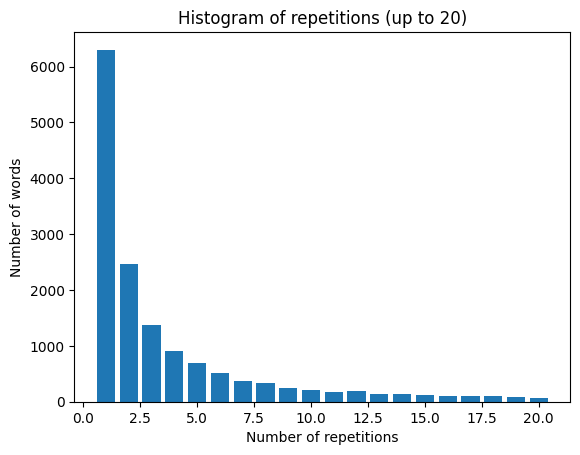

In [86]:
(x_values, y_values) = zip(*hist_quixote[:20])
plt.bar(x_values, y_values)
plt.title('Histogram of repetitions (up to 20)')
plt.xlabel('Number of repetitions')
plt.ylabel('Number of words')
plt.show()

## Exercise 2. Histogram of the length of the words

Provide a histogram of the length of the words. Word repetition is not a problem, so if you have the word 'bye' twice in your document, you would add 2 to the number of words of length 3.

* Length 1 - 100 times
* Length 2 - 300 times
* Length 3 - 400 times
...

You are asked to implement a `histogram_length(file_path)` function in Spark. All the processing must be done with **DataFrames**, and there should be a single `collect()` at the end to return a list. The list must be ordered by the length of the words. Recall removing punctuation symbols when computing the histogram (but don't remove stop words).

**Input**: A text document or multiple text documents

**Output**: (Length, number of words)

**Note:** We are going to assume that the maximum word length is 16 characters, so anything above that shouldn't appear in the result.

In [91]:
def histogram_length(file_path):
    df = spark.read.text(file_path)\
        .select(
            sql_f.explode(
                sql_f.split(
                    remove_punctuation(sql_f.col("value")), ' ')
            ).alias("word")
        ).filter(
            sql_f.col("word") != ''
        ).select(
            sql_f.length("word").alias("word_length")
        ).filter(
            sql_f.col("word_length") <= 16
        ).groupBy("word_length")\
        .count()\
        .orderBy("word_length")
    return df.collect()
    
histogram_length("data/quixote.txt")

[Row(word_length=1, count=16557),
 Row(word_length=2, count=86007),
 Row(word_length=3, count=104061),
 Row(word_length=4, count=85836),
 Row(word_length=5, count=42352),
 Row(word_length=6, count=34381),
 Row(word_length=7, count=29737),
 Row(word_length=8, count=15982),
 Row(word_length=9, count=10454),
 Row(word_length=10, count=6409),
 Row(word_length=11, count=2516),
 Row(word_length=12, count=1210),
 Row(word_length=13, count=482),
 Row(word_length=14, count=152),
 Row(word_length=15, count=60),
 Row(word_length=16, count=7)]

The program should pass the following test:

In [92]:
length_quixote = histogram_length("data/quixote.txt")
print(length_quixote)
test(length_quixote, [(1, 16557), (2, 86007), (3, 104061), (4, 85836), (5, 42352), (6, 34381), (7, 29737),
                                   (8, 15982), (9, 10454), (10, 6409), (11, 2516), (12, 1210), (13, 482), (14, 152),
                                   (15, 60), (16, 7)], "Try again!")

[Row(word_length=1, count=16557), Row(word_length=2, count=86007), Row(word_length=3, count=104061), Row(word_length=4, count=85836), Row(word_length=5, count=42352), Row(word_length=6, count=34381), Row(word_length=7, count=29737), Row(word_length=8, count=15982), Row(word_length=9, count=10454), Row(word_length=10, count=6409), Row(word_length=11, count=2516), Row(word_length=12, count=1210), Row(word_length=13, count=482), Row(word_length=14, count=152), Row(word_length=15, count=60), Row(word_length=16, count=7)]
Test passed.


## Exercise 3. Average length of the words in a document

You are now asked to implement an `average_length(file_path)` function in Spark that provides the average length of the words in a document or documents. All the processing must be done with **DataFrames**, and the last instruction must be the only one returning a result to the driver. Recall removing punctuation symbols before computing the average (but don't remove stop words).

**Input**: A text document or multiple text documents

**Output**: Average length of the words

**Note:** Again, we are going to assume that the maximum word length is 16 characters, so anything above that shouldn't be used to compute the average.

**Hint**: You might be able to use some built-in functions from Spark!

In [102]:
def average_length(file_path):
    df = spark.read.text(file_path)\
        .select(
            sql_f.explode(
                sql_f.split(
                    remove_punctuation(sql_f.col("value")), ' ')
            ).alias("word")
        ).filter(
            sql_f.col("word") != ''
        ).select(
            sql_f.length("word").alias("word_length")
        ).filter(
            sql_f.col("word_length") <= 16
        ).agg(
            sql_f.mean(
                sql_f.col("word_length")
            ).alias("avg_length")
        )
    return df.first()["avg_length"]
    
average_length("data/quixote.txt")

4.144714731443846

The program should pass the following test:

In [103]:
avg = average_length("data/quixote.txt")
test(round(avg, 5), 4.14471, 'Try again!')

Test passed.


## Exercise 4. LastFM list of top 20 most played artists (groups)

You are asked to implement a `top20_artists(file_path)` function using Spark **DataFrames**, which provides the list of the top 20 most listened artists (groups) in the [LastFM 360K users dataset](http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html).

As in the previous lab, we will download the dataset using Python and get a subset of it while developing our solution. Then, you will test it with the whole dataset.

The [LastFM dataset we are going to use](http://ocelma.net/MusicRecommendationDataset/index.html) has the following format (separated by tab character `'\t'`):

    user-id \t artist-id \t artist-name \t number_of_plays

That is, we have a row for each `user-id` and `artist-id` with the number of times the user has played a track from that artists/group.

The function should have the following input and output:

**Input:** LastFM file (`usersha1-artmbid-artname-plays.tsv` or a subset of it) 

**Output:** List of the 20 most played artist/groups ordered by the number of total plays


We will first prepare the data:
* Download it from http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz
* Decompress the file
* Get a subset of data for the first tests

We will start installing `wget` if it is not yet installed in our environment. With `wget` we are able to download any file from the internet using Python (also available in the command line of Unix-based systems).

In [105]:
!pip install wget

  Using cached wget-3.2-py3-none-any.whl


We can now use `wget` to download the dataset (570mb).

In [106]:
import wget
wget.download('http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz', out='data')

100% [..................................................] 569202935 / 569202935

'data/lastfm-dataset-360K.tar.gz'

Once downloaded, we can decompress the file (if something fails, you can also decompress it yourself from the file explorer).

In [107]:
!tar -xzf data/lastfm-dataset-360K.tar.gz -C data/

We will now generate a subset with the first 3000 lines named `sample3000_usersha1-artmbid-artname-plays.tsv`. This will help us testing our solution faster. 

If you are using a UNIX system, you could do this very easily as:

```
!head -n 1000 'data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv' > 'data/lastfm-dataset-360K/sample3000_usersha1-artmbid-artname-plays.tsv'
```

But in case you are not, you can use the following function: 

In [108]:
def get_subset(input_filename, output_filename, num_lines, enc = "utf-8"):
    with open(input_filename, encoding=enc) as openfile:
        with open(output_filename, 'w', encoding=enc) as outfile:
            for i in range(num_lines):
                line = openfile.readline()
                outfile.write(line)

In [109]:
get_subset('data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv','data/lastfm-dataset-360K/sample3000_usersha1-artmbid-artname-plays.tsv', 3000 )

You can now start programming the solution.

**Hint:** It may be useful to read the data explicitly defining the schema.

In [117]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType # import data types from Spark

def top20_artists(file_path):
    
    schema = StructType(
        [
            StructField("user-id", StringType(), False),
            StructField("artist-id", StringType(), False),
            StructField("artist-name", StringType(), False),
            StructField("plays", IntegerType(), False)
        ]
    )
    
    df = spark.read.option("delimiter", "\\t").schema(schema).csv(file_path)\
        .select(
            sql_f.col("artist-name"),
            sql_f.col("plays")
        ).groupBy("artist-name")\
        .agg(
            sql_f.sum(
                sql_f.col("plays")
            ).alias("total-plays")
        ).orderBy("total-plays", ascending=False)\
        .limit(20)
    return df.collect()
    
top20_artists('./data/lastfm-dataset-360K/sample3000_usersha1-artmbid-artname-plays.tsv')
#top20_artists('./data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv')

[Row(artist-name='radiohead', total-plays=13117),
 Row(artist-name='the most serene republic', total-plays=12763),
 Row(artist-name='nine inch nails', total-plays=11686),
 Row(artist-name='arctic monkeys', total-plays=10943),
 Row(artist-name='stars', total-plays=9045),
 Row(artist-name='the beatles', total-plays=8682),
 Row(artist-name='3 na bossa', total-plays=7925),
 Row(artist-name='coldplay', total-plays=7899),
 Row(artist-name='broken social scene', total-plays=6711),
 Row(artist-name='kingston wall', total-plays=5992),
 Row(artist-name='bright eyes', total-plays=5914),
 Row(artist-name='the libertines', total-plays=5727),
 Row(artist-name='have heart', total-plays=5361),
 Row(artist-name='boris', total-plays=5337),
 Row(artist-name='sigur rós', total-plays=5177),
 Row(artist-name='luminous orange', total-plays=5120),
 Row(artist-name='blink-182', total-plays=4660),
 Row(artist-name='they might be giants', total-plays=4558),
 Row(artist-name='queen', total-plays=4451),
 Row(artis

The program should pass the following tests.

In [118]:
top20_artists_small = top20_artists('./data/lastfm-dataset-360K/sample3000_usersha1-artmbid-artname-plays.tsv')
test(top20_artists_small, [(u'radiohead', 13117), (u'the most serene republic', 12763), (u'nine inch nails', 11686),
                                       (u'arctic monkeys', 10943), (u'stars', 9045), (u'the beatles', 8682), (u'3 na bossa', 7925),
                                       (u'coldplay', 7899), (u'broken social scene', 6711), (u'kingston wall', 5992), (u'bright eyes', 5914),
                                       (u'the libertines', 5727), (u'have heart', 5361), (u'boris', 5337), (u'sigur r\xf3s', 5177), 
                                       (u'luminous orange', 5120), (u'blink-182', 4660), (u'they might be giants', 4558), (u'queen', 4451), 
                                       (u'bob dylan', 4443)],
                  'Try it again!')

Test passed.


When running the largest dataset, you can take a look to its progress at <http://localhost:4040> or at the command line. If it takes too long in your PC, running the previous test should be enough. You should notice a great performance improvement with respect to using RDDs.

In [119]:
top20_artists_big = top20_artists('./data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv')
test(top20_artists_big, [(u'the beatles', 30499140), (u'radiohead', 27452136), (u'coldplay', 16701858), (u'pink floyd', 15965959), 
                                     (u'metallica', 15498759), (u'muse', 15463089), (u'nine inch nails', 14090643), (u'red hot chili peppers', 13562637),
                                     (u'linkin park', 12848569), (u'system of a down', 11927204), (u'in flames', 11295957), 
                                     (u'death cab for cutie', 10587605), (u'placebo', 9848924), (u'nightwish', 9765770), (u'the killers', 9607866), 
                                     (u'iron maiden', 9509435), (u'bob dylan', 9454759), (u'nirvana', 9284068), (u'depeche mode', 9243291), 
                                     (u'rammstein', 8809758)],
                  'Try it again!')

[Stage 233:>                                                        (0 + 4) / 4]

Test passed.


## Exercise 5. LastFM list of the top 20 most popular artists (groups)

You are asked to implement a `top20_popular_artists(file_path)` function using Spark **DataFrames**, which provides the list of the top 20 most popular artists (groups) in the [LastFM 1K users dataset](http://ocelma.net/MusicRecommendationDataset/lastfm-1K.html). We will measure popularity in terms of the number of different (unique) users that have played an artist (group). This means that each user will count only once for each artist. Note that the same `user-id` and `artist-id` may be repeated more than once in the dataset.

Unlike the previous exercise, we will use another [LastFM dataset](http://ocelma.net/MusicRecommendationDataset/index.html) dataset available that contains the full listening history of 1000 users. This dataset has the following format (separated by tab character `'\t'`):

    user-id \t timestamp \t artist-id \t artist-name \t track-id \t trackname

That is, we have a row for each time a track is played by a `user-id`.

The function should have the following input and output:

**Input:** LastFM file (`userid-timestamp-artid-artname-traid-traname.tsv` or a subset of it) 

**Output:** List of the 20 most popular artist/groups ordered by the number of unique users


**Note:** There are different ways to solve this problem. You can try to think which one will be more efficient (for example, in terms of network traffic).

We will first prepare the data:
* Download it from http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
* Decompress the file
* Get a subset of data for the first tests

If you haven't done it before, you need to install `wget` if it is not yet installed in our environment

In [ ]:
!pip install wget

We can now use `wget` to download the dataset (670mb).

In [120]:
import wget
wget.download('http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz', out='data')

100% [..................................................] 672741554 / 672741554

'data/lastfm-dataset-1K.tar.gz'

Once downloaded, we can decompress the file (if something fails, you can also decompress it yourself from the file explorer).

In [121]:
# Decompress the data
!tar -xzf data/lastfm-dataset-1K.tar.gz -C data/

We will now generate a subset with the first 3000 lines named `sample3000_userid-timestamp-artid-artname-traid-traname.tsv`. This will help us testing our solution faster.

In [122]:
import random

def get_random_subset(input_filename, output_filename, num_lines, enc = "iso8859-1"):
    random.seed(12314)

    with open(input_filename, encoding=enc) as openfile:
        with open(output_filename, 'w', encoding=enc) as outfile:
            openfile.seek(0, 2)
            filesize = openfile.tell()
            random_set = sorted(random.sample(range(filesize), num_lines))

            for i in range(num_lines):
                openfile.seek(random_set[i])
                openfile.readline() # first line may be in the middle
                outfile.write(openfile.readline())             


In [123]:
get_random_subset('data/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', 'data/lastfm-dataset-1K/sample3000_userid-timestamp-artid-artname-traid-traname.tsv',3000)

Now, we can start developing the solution:

In [129]:
from pyspark.sql.types import StringType, StructField, TimestampType # import data types from Spark

def top20_popular_artists(file_path):

    schema = StructType(
        [
            StructField("user-id", StringType(), False),
            StructField("timestamp", TimestampType(), False),
            StructField("artist-id", StringType(), False),
            StructField("artist-name", StringType(), False),
            StructField("track-id", StringType(), False),
            StructField("track-name", StringType(), False)
        ]
    )
    
    output = spark.read.option("delimiter", "\\t").schema(schema).csv(file_path)\
        .select(
            sql_f.col("user-id"),
            sql_f.col("artist-name")
        ).groupBy(
            sql_f.col("user-id"),
            sql_f.col("artist-name")
        ).count()\
        .groupBy("artist-name")\
        .count()\
        .orderBy("count", ascending=False)\
        .limit(20)
    return output.collect()

%time print(top20_popular_artists('./data/lastfm-dataset-1K/sample3000_userid-timestamp-artid-artname-traid-traname.tsv'))
# %time print(top20_popular_artists('./data/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv'))

[Row(artist-name='The Beatles', count=21), Row(artist-name='Muse', count=13), Row(artist-name='Nine Inch Nails', count=12), Row(artist-name='Interpol', count=11), Row(artist-name='Coldplay', count=10), Row(artist-name='Depeche Mode', count=10), Row(artist-name='Radiohead', count=10), Row(artist-name='System Of A Down', count=10), Row(artist-name='Placebo', count=9), Row(artist-name='Sonic Youth', count=9), Row(artist-name='Pink Floyd', count=9), Row(artist-name='The Cure', count=8), Row(artist-name='Sigur Rós', count=8), Row(artist-name='Arctic Monkeys', count=8), Row(artist-name='Snow Patrol', count=8), Row(artist-name='Black Rebel Motorcycle Club', count=7), Row(artist-name='The Shins', count=7), Row(artist-name='U2', count=7), Row(artist-name='Bloc Party', count=7), Row(artist-name='The Rolling Stones', count=7)]
CPU times: user 8.42 ms, sys: 1.76 ms, total: 10.2 ms
Wall time: 849 ms


The program should pass the following tests.

In [130]:
top20_popular_artists_small = top20_popular_artists('./data/lastfm-dataset-1K/sample3000_userid-timestamp-artid-artname-traid-traname.tsv')
test(sorted(top20_popular_artists_small[:-5], key=lambda t: (-t[1], t[0])), 
                                         sorted([('The Beatles', 21), ('Muse', 13), ('Nine Inch Nails', 12), ('Interpol', 11),
                                                ('Depeche Mode', 10), ('System Of A Down', 10), ('Coldplay', 10), ('Radiohead', 10),
                                                ('Sonic Youth', 9), ('Pink Floyd', 9), ('Placebo', 9), ('Arctic Monkeys', 8),
                                                ('The Cure', 8), ('Sigur Rós', 8), ('Snow Patrol', 8)],
                                        key=lambda t: (-t[1], t[0])),
                  'Try it again!')

Test passed.


When running the largest dataset, you can take a look to its progress at <http://localhost:4040> or at the command line.

If it takes too long in your PC, running the first test should be enough.  You should notice a great performance improvement with respect to using RDDs.

In [131]:
top20_popular_artists_big = top20_popular_artists('./data/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv')
test(sorted(top20_popular_artists_big, key=lambda t: (-t[1], t[0])), 
                                    sorted([('Radiohead', 710), ('Coldplay', 637), ('The Beatles', 615), ('Muse', 595),
                                              ('The Cure', 577), ('The Killers', 577), ('Red Hot Chili Peppers', 572), 
                                              ('Nirvana', 564), ('The White Stripes', 562), ('Franz Ferdinand', 562),
                                              ('Beck', 560), ('David Bowie', 560), ('Depeche Mode', 558), ('Air', 552),
                                              ('Pink Floyd', 539), ('Massive Attack', 538), ('Daft Punk', 538), ('U2', 534),
                                              ('The Smashing Pumpkins', 528), ('Gorillaz', 523)], key=lambda t: (-t[1], t[0])),
                  'Try it again!')

[Stage 253:>                                                        (0 + 4) / 4]

Test passed.


# Part II - Use case on Twitter data analysis

For the remainder of the lab, we will make use of a dataset of tweets collected during the campaign of the 2012 US elections. Although we prefer to stay out of politics, this is a great source of data to work with Spark DataFrames and understand their usefulness and how they work. Anyway, we will simply perform an objective analysis of the data.

This big dataset was published at [Data Hub](https://datahub.io), where it is not currently available in its original [(broken) link](https://datahub.io/dataset/twitter-2012-presidential-election). However, thanks to the [Internet Archive](https://archive.org/) project, we can still get access to it through this [link](https://web.archive.org/web/20150831144839/http://datahub.io:80/dataset/twitter-2012-presidential-election). We are grateful to [Peter Molnar](https://github.com/kingmolnar) for sharing this dataset with the community.

You will notice that the dataset is huge, with more than 170M tweets. Using all of it wouldn't be flexible enough for this lab, so we will focus on the first 1 million tweets (about 400MB compressed and 3GB of data decompressed). Therefore, you need to download the first set of tweets following the link to the file named `cache-0.json.gz` ([direct link](https://web.archive.org/web/20150831144839/https://ckannet-storage.commondatastorage.googleapis.com/2015-07-09T02:10:43.036Z/cache-0-json.gz)). Once downloaded, put it into your `data` folder.

You may have noticed that this dataset contains all the tweets related to the 2012 US presidential election campaign where Mitt Romney (Republican) and Barack Obama (Democrat) faced each other. To establish which tweets were related to the elections, a series of search terms were chosen.  Leaving aside the debate of whether the terms chosen are all the necessary ones, in this lab we will focus on analyzing the data from this set, assuming that the data capture is not perfect. This election was relevant in the field of social media and Big Data analysis because a part of Barack Obama's success in winning the election was, in part, attributed to the use of these technologies. Was it true or marketing? We will try to learn more about it now.


<!-- REVISAR

https://github.com/kingmolnar
https://data.wu.ac.at/schema/datahub_io/Nzk5MWM0Y2ItNThmYS00ODVkLThkN2UtZWM5NjRhMWU3MjA5
https://web.archive.org/web/20150718043646/https://datahub.io/dataset/twitter-2012-presidential-election
https://discuss.okfn.org/t/dataset-no-longer-found-on-datahub/6611

can read compressed json?

**Acceso actual:** https://web.archive.org/web/20150831144839/http://datahub.io:80/dataset/twitter-2012-presidential-election

**Descarga:** https://web.archive.org/web/20150831144839/https://ckannet-storage.commondatastorage.googleapis.com/2015-07-09T02:10:43.036Z/cache-0-json.gz

**Terms of Use**

If you find this data-set useful, please, let me know. I would appreciate being credited as the provider of the data in any publication that utilizes these data. 

Peter Molnar peter@kingmolnar.com
https://github.com/kingmolnar


**Twitter 2012 Presidential Election**

This data-set contains over 170,000,000 tweets collected during 3 months leading up to the 2012 presidential elections.
Format

The data-set is split up into files with about 1,000,000 to 10,000,000 status records in JSON format. The files are individually compressed with 'gzip'. Each individual file is valid. I suggest piping it through 'zcat' when reading in, rather than uncompressing the entire file.

**Terms of Use**

If you find this data-set useful, please, let me know. I would appreciate being credited as the provider of the data in any publication that utilizes these data.

**The search terms were**

Abortion, Afghanistan, AfricanAmerican, Ambassador, AnneRomney, AUC, Bengali, BirthCertificate, Birther, Black, BlackVoter, Bluestates, CAU, ChristopherStephens, Congress, Conservative, CivilRights, Debt, Democrat, DINO, economy, Embassy, energy, gas, HBCU, Heathcare, HHS, Hurricane, Iran, Israel, Jerusalem, Liberal, Libya, Media, MichelleObama, MiddleClass, MidWest, Mitt, Morehouse, Moveon, MarriageEquality, NAACP, Nationaldebt, Obama, Obamacare, Pakistan, PaulRyan, Poll, Poor, POTUS, Purplestates, Prolive, Parenthood, Redstates, Republican, Rich, RINO, Romney, Romneycare, Senate, South, Spelman, SwingState, Taxes, TeaParty, Undecided, VoterID, VotingRights, West, Yemen, Youth, Youthvote

**Sample**

{ "created_at": "Fri Dec 21 22:53:46 +0000 2012", "id": 282257583836889090, "id_str": "282257583836889090", "text": "Obama meets Reid on fiscal cliff, plans remarks http://t.co/Nuec5Wh6", "source": "twitterfeed", "truncated": false, "in_reply_to_status_id": null, "in_reply_to_status_id_str": null, "in_reply_to_user_id": null, "in_reply_to_user_id_str": null, "in_reply_to_screen_name": null, "user": { "id": 27703934, "id_str": "27703934", "name": "Washington Examiner", "screen_name": "washexaminer", "location": "Washington DC", "url": "http://www.washingtonexaminer.com", "description": "", "protected": false, "followers_count": 1995, "friends_count": 67, "listed_count": 94, "created_at": "Mon Mar 30 18:56:55 +0000 2009", "favourites_count": 0, "utc_offset": -18000, "time_zone": "Eastern Time (US & Canada)", "geo_enabled": true, "verified": false, "statuses_count": 42208, "lang": "en", "contributors_enabled": false, "is_translator": false, "profile_background_color": "FFFFFF", "profile_background_image_url": "http://a0.twimg.com/profile_background_images/553522199/twitter-design-Sections1.jpg", "profile_background_image_url_https": "https://si0.twimg.com/profile_background_images/553522199/twitter-design-Sections1.jpg", "profile_background_tile": false, "profile_image_url": "http://a0.twimg.com/profile_images/2223644256/logo-social_normal.gif", "profile_image_url_https": "https://si0.twimg.com/profile_images/2223644256/logo-social_normal.gif", "profile_link_color": "CA0613", "profile_sidebar_border_color": "C0DEED", "profile_sidebar_fill_color": "DDEEF6", "profile_text_color": "333333", "profile_use_background_image": true, "default_profile": false, "default_profile_image": false, "following": null, "follow_request_sent": null, "notifications": null }, "geo": null, "coordinates": null, "place": null, "contributors": null, "retweet_count": 0, "entities": { "hashtags": [], "urls": [ { "url": "http://t.co/Nuec5Wh6", "expanded_url": "http://bit.ly/UWIjMN", "display_url": "bit.ly/UWIjMN", "indices": [ 48, 68 ] } ], "user_mentions": [] }, "favorited": false, "retweeted": false, "possibly_sensitive": false, "lang": "en" }



**NOTA:** Se puede añadir algo de sentiment analyiss de los tweets basado en conteos de palabras o emoticonos -->

## 1. Data loading and first look

Let's start reading the dataset (in compressed JSON format, you don't need to decompress it). Recall to **cache** it, so we don't have to read it continuously from disk.

In [3]:
tweet_df = spark.read.option("compression", "gzip").json('./data/cache-0-json.gz').cache()

<!-- #### How many tweets do we have available for analysis? -->

Check now how many tweets are available for the analysis. There should be exactly a million of tweets.

In [4]:
n_tweets = tweet_df.count()

25/12/06 14:05:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/12/06 14:06:05 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
25/12/06 14:06:05 WARN BlockManager: Persisting block rdd_7_0 to disk instead.
25/12/06 14:06:47 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
25/12/06 14:06:48 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
                                                                                

In [5]:
test(n_tweets, 1000000, 'Try again!')

Test passed.


If you have taken a look at the information on the dataset, you will have noticed that the tweets do not only come with the text but are accompanied by a lot of other information. Let's take a look at the data schema that Spark SQL has obtained from the JSON

In [6]:
tweet_df.printSchema()

root
 |-- contributors: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |  

Wow! There are lots of fields for each tweet! 

It will probably also help you to see the content of the first row of the DataFrame (the first tweet).

In [7]:
tweet_df.first()

25/12/06 14:07:42 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
                                                                                

Row(contributors=None, coordinates=None, created_at='Sun Sep 09 21:17:55 +0000 2012', entities=Row(hashtags=[Row(indices=[87, 95], text='florida')], media=None, urls=[Row(display_url='STLtoday.com', expanded_url='http://STLtoday.com', indices=[45, 65], url='http://t.co/OcISvreb'), Row(display_url='bit.ly/Tzhmly', expanded_url='http://bit.ly/Tzhmly', indices=[66, 86], url='http://t.co/FsJ7xgGW')], user_mentions=[]), favorited=False, geo=None, id=244907511377965056, id_str='244907511377965056', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, place=None, possibly_sensitive=False, possibly_sensitive_editable=True, retweet_count=0, retweeted=False, retweeted_status=None, source='<a href="http://twitterfeed.com" rel="nofollow">twitterfeed</a>', text='Obama vies for health care edge in Florida - http://t.co/OcISvreb http://t.co/FsJ7xgGW #florida', truncated=False, user=Row(contributors_enabled=Fa

If you look at the columns in the DataFrame, you will see that there aren't as many:

In [8]:
tweet_df.columns

['contributors',
 'coordinates',
 'created_at',
 'entities',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'place',
 'possibly_sensitive',
 'possibly_sensitive_editable',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'user']

However, most of the columns are structures with additional fields.

## 2. Filtering fields

Not all the fields are interesting or are going to be useful for this lab, so we will filter some of them.

Create a new DataFrame, named `df`, containing only the data corresponding to the following columns/fields:
* *id* - unique Tweet id. Rename it as *tweet_id*.
* *user.name* - user display name shown in the Tweet. Rename it as *displayed_username*.
* *user.screen_name* - username identifier (the unique id that corresponds to the @ in Twitter). Rename it as *username_id*.
* *user.followers_count* - number of followers of the user.
* *text* - text of the Tweet.
* *retweet_count* - Number of retweets of the Tweet.
* *place.country* - Country where the Tweet was published.
* *entities.user_mentions* - Mentions to other users in the Tweet (using @user).
* *entities.hashtags* - Hashtags present in the Tweet (using #hashtag).
* *created_at* - When the Tweet was posted.

In [4]:
df = tweet_df.select(
    sql_f.col('id').alias('tweet_id'),
    sql_f.col('user.name').alias('displayed_username'),
    sql_f.col('user.screen_name').alias('username_id'),
    sql_f.col('user.followers_count'),
    sql_f.col('text'),
    sql_f.col('retweet_count'),
    sql_f.col('place.country'),
    sql_f.col('entities.user_mentions'),
    sql_f.col('entities.hashtags'),
    sql_f.col('created_at')
)
df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- displayed_username: string (nullable = true)
 |-- username_id: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- text: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- country: string (nullable = true)
 |-- user_mentions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- created_at: string (nullable = true)



In [11]:
test(df.columns, ['tweet_id', 'displayed_username', 'username_id', 'followers_count', 'text', 'retweet_count',
                               'country', 'user_mentions', 'hashtags', 'created_at'],
                 'Try again!')

Test passed.


Check the schema of the new DataFrame.

In [12]:
df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- displayed_username: string (nullable = true)
 |-- username_id: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- text: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- country: string (nullable = true)
 |-- user_mentions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- created_at: string (nullable = true)



It seems more manageable now, doesn't it? So let's start analyzing the data.

## 3. First insights

Let's begin by understanding more about the data we are working with by running some simple queries to answer some questions.

### Number of Twitter users involved

We already know that we have a million Tweets, but how many people are responsible for generating those million tweets?

In [21]:
n_people = df.select(
    sql_f.col('username_id')
).distinct()\
.groupBy(
    sql_f.col('username_id')
).count().\
agg(
    sql_f.sum('count').alias('count')
).first()[0]
n_people

25/12/06 14:28:12 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
                                                                                

580606

In [22]:
test(n_people, 580606)

Test passed.


### Top 10 users who post the most

Let's now investigate those half million users to determine who are the top 10 users in terms of posted Tweets. To do so, create a DataFrame with the number of Tweets posted by each user sorted by the number of Tweets (in descending order). You should consider using the `username_id` of the user for this query, since the username in `displayed_username` may not be unique.

In [24]:
users_n_tweets_df = df.select(
    sql_f.col('username_id')
).groupBy(
    sql_f.col('username_id')
).count()\
.orderBy('count', ascending=False)

users_n_tweets_df.show(10)

25/12/06 14:32:16 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+---------------+-----+
|    username_id|count|
+---------------+-----+
|    National_WX|  993|
|TripleXDiamonds|  712|
|   MyBridalRing|  711|
|    RingDesigns|  710|
|     EnvyMyRing|  694|
| CelebrityRings|  690|
| Bridal_Ringset|  690|
|followfriday_us|  637|
| Psoriasis_Care|  580|
|     PowerDaily|  449|
+---------------+-----+
only showing top 10 rows


In [25]:
users_n_tweets_df = df.select(
    sql_f.col('displayed_username')
).groupBy(
    sql_f.col('displayed_username')
).count()\
.orderBy('count', ascending=False)

users_n_tweets_df.show(10)

25/12/06 14:33:08 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+--------------------+-----+
|  displayed_username|count|
+--------------------+-----+
|    The Action Group| 9762|
|    National Weather|  993|
|     TripleXDiamonds|  712|
|BrillianceEngagement|  711|
| BrilliantEngagement|  710|
|   EngagementDiamond|  694|
|      Bridal_Ringset|  690|
|   Celebrity Jewelry|  690|
|FollowFriday Ranking|  637|
|      Psoriasis Care|  580|
+--------------------+-----+
only showing top 10 rows


Try to do the same using the `displayed_username` instead o the `username_id`. Do you see any difference?

In [28]:
users_n_tweets_df = df.select(
    sql_f.col('displayed_username')
).groupBy(
    sql_f.col('displayed_username')
).count()\
.orderBy('count', ascending=False)

users_n_tweets_df.show(10)

25/12/06 14:35:10 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
[Stage 57:>                                                         (0 + 1) / 1]

+--------------------+-----+
|  displayed_username|count|
+--------------------+-----+
|    The Action Group| 9762|
|    National Weather|  993|
|     TripleXDiamonds|  712|
|BrillianceEngagement|  711|
| BrilliantEngagement|  710|
|   EngagementDiamond|  694|
|      Bridal_Ringset|  690|
|   Celebrity Jewelry|  690|
|FollowFriday Ranking|  637|
|      Psoriasis Care|  580|
+--------------------+-----+
only showing top 10 rows


In [29]:
test(users_n_tweets_df.take(10), [('The Action Group', 9762), ('National Weather', 993), ('TripleXDiamonds', 712), ('BrillianceEngagement', 711),
                                  ('BrilliantEngagement', 710), ('EngagementDiamond', 694), ('Celebrity Jewelry', 690), ('Bridal_Ringset', 690),
                                  ('FollowFriday Ranking', 637), ('Psoriasis Care', 580)])

25/12/06 14:35:14 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


Test passed.


That username with almost 10K Tweets didn't appear in our previous query!

Let's try to solve this mystery. How many unique usernames (`username_id`) have been used by each `displayed_username`?

In [31]:
user_names_df = df.select(
     sql_f.col('displayed_username'),
     sql_f.col('username_id')
).dropDuplicates(['displayed_username', 'username_id'])\
.groupBy(
    sql_f.col('displayed_username')
).count()\
.select(
    sql_f.col('displayed_username'),
    sql_f.col('count')
).orderBy('count', ascending=False)

user_names_df.show(20)

25/12/06 14:40:42 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
[Stage 65:>                                                         (0 + 4) / 4]

+------------------+-----+
|displayed_username|count|
+------------------+-----+
|                 .|  229|
|  The Action Group|  211|
|             Chris|  131|
|             David|  120|
|              Alex|  118|
|                 †|  102|
|           Michael|   99|
|                 ∞|   94|
|              Matt|   91|
|             Sarah|   89|
|              Mike|   85|
|                 ♥|   83|
|             Laura|   82|
|               ...|   77|
|              Ryan|   77|
|            Amanda|   75|
|             James|   74|
|              Nick|   73|
|           Jessica|   73|
|             Emily|   72|
+------------------+-----+
only showing top 20 rows


In [32]:
test(user_names_df.take(10), [('.', 229), ('The Action Group', 211), ('Chris', 131), ('David', 120), ('Alex', 118), ('†', 102),
                                  ('Michael', 99), ('∞', 94), ('Matt', 91), ('Sarah', 89)])

25/12/06 14:40:53 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


Test passed.


This is rather curious, there are several usernames that can be repeated just because there are many users with the same display name (like 'Chris' or 'David'). However, it is somewhat strange that two hundred users are using the same 'The Action Group' display name. 

### Users with the largest Tweets

We will now focus on the length of the Tweets posted. We want to know the average length of Tweets per user, ordered from longest to shortest. Use that information to get who is the user with the longest average length. We will only consider those Twitter accounts that have posted more than 100 tweets.

Steps to follow:
1. Use a `select()` to get the length of the Tweet along with each username (`username_id`).
2. Group by username and obtain the average length and count.
3. Filter by count (> 100).
5. Sort by average length.
6. Get the name of the first user.

In [36]:
#df.printSchema()

In [41]:
users_tweet_len_df = df.select(
    sql_f.col('username_id'),
    sql_f.length('text').alias('text_length')
).groupBy(
    sql_f.col('username_id')
).agg(
    sql_f.mean('text_length').alias('avg_text_len'),
    sql_f.count('text_length').alias('count')
).filter(
    sql_f.col('count') > 100
).orderBy('avg_text_len', ascending=False)
user = users_tweet_len_df.select('username_id').first()[0]
users_tweet_len_df.show(10)
user

25/12/06 14:55:59 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
25/12/06 14:56:05 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+---------------+------------------+-----+
|    username_id|      avg_text_len|count|
+---------------+------------------+-----+
| TheCypressGang|143.73643410852713|  129|
| tobreakthenews|      139.53515625|  256|
|   incognito912|137.53454545454545|  275|
|      WaterWynd|137.33333333333334|  192|
|      onevoice2| 136.5148514851485|  101|
| USA_Internship|136.29807692307693|  104|
|   marineagency| 136.2941176470588|  102|
|    severewxman|      136.01171875|  256|
|  chaseboyerSVN|             136.0|  229|
|FloridaWXalerts|             136.0|  159|
+---------------+------------------+-----+
only showing top 10 rows


'TheCypressGang'

In [42]:
test(user, 'TheCypressGang', 'Try again!')
test(list(map(lambda t: (t[0], round(t[1], 4), t[2]), users_tweet_len_df.take(10))), 
        [('TheCypressGang', 143.7364, 129), ('tobreakthenews', 139.5352, 256), ('incognito912', 137.5345, 275),
         ('WaterWynd', 137.3333, 192), ('onevoice2', 136.5149, 101), ('USA_Internship', 136.2981, 104),
         ('marineagency', 136.2941, 102), ('severewxman', 136.0117, 256), ('FloridaWXalerts', 136.0, 159),
         ('chaseboyerSVN', 136.0, 229)] , 'Try again!')

Test passed.


25/12/06 14:56:10 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
[Stage 94:>                                                         (0 + 1) / 1]

Test passed.


### Tweets' origin

When working with a dataset of the US presidential elections, one would think that the majority of Tweets would come from the US. Let's check if this is the case by obtaining the number of Tweets posted for each country (only possible for those Tweets that have the country set).

In [44]:
#df.printSchema()

In [61]:
tweets_per_country_df = df.select(
    sql_f.col('country')
).filter(
    sql_f.col('country').isNotNull()
).groupBy(
    sql_f.col('country')
).count()\
.orderBy(['count', 'country'], ascending=[False, True])

tweets_per_country_df.show(10)

25/12/06 15:08:47 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
[Stage 142:>                                                        (0 + 1) / 1]

+--------------+-----+
|       country|count|
+--------------+-----+
| United States| 5240|
|        Brasil| 1212|
|United Kingdom|  386|
|       Germany|  223|
|     Indonesia|  188|
|         Spain|  188|
|        Mexico|  174|
|         Italy|  150|
|        Canada|  121|
|        France|   94|
+--------------+-----+
only showing top 10 rows


In [62]:
test(tweets_per_country_df.take(10), [(u'United States', 5240), (u'Brasil', 1212), (u'United Kingdom', 386), (u'Germany', 223), 
                                      (u'Indonesia', 188), (u'Spain', 188), (u'Mexico', 174), (u'Italy', 150), (u'Canada', 121), 
                                      (u'France', 94)], 'Try again!')

25/12/06 15:08:55 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


Test passed.


### About time

Let's now get some insights about when the Tweets were posted. We already know that we are working with a subset of the whole dataset (with 170M Tweets), but how many days are we covering? Obtain the date of the first and the last Tweet in the DataFrame.

**Note:** You may notice that the `created_at` column is of String type in the schema, instead of a TimeStamp or DateTime type. This means that we cannot work directly with dates, so we need to first convert that to the right format.

We recommend you to take a look at how to parse this data in [Spark SQL documentation](https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html). There is a small problem with the date format used in the `created_at` column. Let's see it.

In [63]:
df.select('created_at').show(10, truncate=False)

+------------------------------+
|created_at                    |
+------------------------------+
|Sun Sep 09 21:17:55 +0000 2012|
|Sun Sep 09 21:17:55 +0000 2012|
|Sun Sep 09 21:17:55 +0000 2012|
|Sun Sep 09 21:17:55 +0000 2012|
|Sun Sep 09 21:17:55 +0000 2012|
|Sun Sep 09 21:17:55 +0000 2012|
|Sun Sep 09 21:17:55 +0000 2012|
|Sun Sep 09 21:17:56 +0000 2012|
|Sun Sep 09 21:17:56 +0000 2012|
|Sun Sep 09 21:17:56 +0000 2012|
+------------------------------+
only showing top 10 rows


25/12/06 15:09:43 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
                                                                                

You can observe that the timestamp is given as: day of the week, month, day of the month, time, timezone and year. The problem is that, as stated [in the previous link]((https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html), the formatting corresponding to the day of the week ('Sun' for example) is only expected to be used in output formatting of time data, but not to be parsed. We can try to convert this using the pattern `"EEE MMM dd HH:mm:ss Z yyyy"`, but we will get an error:

In [64]:
df.select(sql_f.to_timestamp('created_at', 'EEE MMM dd HH:mm:ss Z yyyy')).show(10)

SparkUpgradeException: [INCONSISTENT_BEHAVIOR_CROSS_VERSION.DATETIME_PATTERN_RECOGNITION] You may get a different result due to the upgrading to Spark >= 3.0:
Fail to recognize 'EEE MMM dd HH:mm:ss Z yyyy' pattern in the DateTimeFormatter.
1) You can set "spark.sql.legacy.timeParserPolicy" to "LEGACY" to restore the behavior before Spark 3.0.
2) You can form a valid datetime pattern with the guide from 'https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html'. SQLSTATE: 42K0B

You will see that it has to do with a change in Spark 3.0 regarding which strings can be parsed. As said before, 
> Symbols of ‘E’, ‘F’, ‘q’ and ‘Q’ can only be used for datetime formatting, e.g. date_format. They are not allowed to be used for datetime parsing, e.g. to_timestamp.

However, we can change the Spark configuration to allow for this modifying the `'spark.sql.legacy.timeParserPolicy'` option to `'LEGACY'`.

In [65]:
spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')

We will also change another parameter in the configuration regarding the time zone. This is simply required to ensure that the results in this notebook don't change depending on where you are running it. So we will work with Coordinated Universal Time (UTC).

In [66]:
spark.conf.set("spark.sql.session.timeZone", "UTC")

Now, we could do the trick:

In [67]:
df.select(sql_f.to_timestamp('created_at', 'EEE MMM dd HH:mm:ss Z yyyy')).show(10)

25/12/06 15:10:58 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+----------------------------------------------------+
|to_timestamp(created_at, EEE MMM dd HH:mm:ss Z yyyy)|
+----------------------------------------------------+
|                                 2012-09-09 21:17:55|
|                                 2012-09-09 21:17:55|
|                                 2012-09-09 21:17:55|
|                                 2012-09-09 21:17:55|
|                                 2012-09-09 21:17:55|
|                                 2012-09-09 21:17:55|
|                                 2012-09-09 21:17:55|
|                                 2012-09-09 21:17:56|
|                                 2012-09-09 21:17:56|
|                                 2012-09-09 21:17:56|
+----------------------------------------------------+
only showing top 10 rows


Make sure that you now add this new Column to the DataFrame. Name it as `'timestamp'`.

In [69]:
new_df = df.select(
    '*',
    sql_f.to_timestamp('created_at', 'EEE MMM dd HH:mm:ss Z yyyy').alias('timestamp')
)
new_df.show(3)
new_df.printSchema()

+------------------+------------------+-------------+---------------+--------------------+-------------+-------+-------------+--------------------+--------------------+-------------------+
|          tweet_id|displayed_username|  username_id|followers_count|                text|retweet_count|country|user_mentions|            hashtags|          created_at|          timestamp|
+------------------+------------------+-------------+---------------+--------------------+-------------+-------+-------------+--------------------+--------------------+-------------------+
|244907511377965056|      Florida News|   FLnewswire|           3214|Obama vies for he...|            0|   NULL|           []|[{[87, 95], flori...|Sun Sep 09 21:17:...|2012-09-09 21:17:55|
|244907511310843906|    Jessica Rutley|JessicaRutley|             94|Just crossed the ...|            0|   NULL|           []|[{[88, 92], USA},...|Sun Sep 09 21:17:...|2012-09-09 21:17:55|
|244907512317476864|      Florida News|   FLnewswire|  

25/12/06 15:15:25 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
                                                                                

In [70]:
df = new_df

In [71]:
from pyspark.sql.types import TimestampType
test(df.schema['timestamp'].dataType, TimestampType(), 'Try again!')

Test passed.


We can now work with date and time properly. It's time to get the date of the first and the last Tweet in the DataFrame.

In [72]:
first_last_df = df.select(
    sql_f.col('timestamp')
).agg(
    sql_f.min('timestamp').alias('first'),
    sql_f.max('timestamp').alias('last')
)
first_last_df.show(truncate=False)

25/12/06 15:19:09 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+-------------------+-------------------+
|first              |last               |
+-------------------+-------------------+
|2012-09-09 21:17:55|2012-09-13 01:30:22|
+-------------------+-------------------+



In [73]:
from datetime import datetime
import pytz
test(tuple(map(lambda d: d.astimezone(pytz.UTC), first_last_df.first())), 
                            (datetime(2012, 9, 9, 21, 17, 55, tzinfo=pytz.UTC),
                             datetime(2012, 9, 13, 1, 30, 22, tzinfo=pytz.UTC)), 'Try it again!')

25/12/06 15:19:23 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


Test passed.


You are now asked to calculate the number of Tweets posted each day. You may need to take a look at the [Datetime functions from Spark SQL](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html#datetime-functions).

In [78]:
n_tweets_day_df = df.select(
    sql_f.to_date('timestamp').alias('date')
).groupBy(
    sql_f.col('date')
).count()\
.orderBy('date')
n_tweets_day_df.show()

25/12/06 15:30:54 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+----------+------+
|      date| count|
+----------+------+
|2012-09-09| 94047|
|2012-09-10|606285|
|2012-09-11|272135|
|2012-09-13| 27533|
+----------+------+



In [79]:
from datetime import date
test(n_tweets_day_df.take(10), [(date(2012, 9, 9), 94047), (date(2012, 9, 10), 606285),
                                (date(2012, 9, 11), 272135), (date(2012, 9, 13), 27533)],
     'Try it again!')

25/12/06 15:31:09 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


Test passed.


We don't know why, but there seem to be no Tweets from the 12th of September. There could be fewer Tweets for the 9th because the capture could have started during the day (in fact, the first Tweet is from 9 PM). Likewise, the Tweets from the 13th would probably be present in the next data chunk that we didn't download.

Can we learn something about which were the hours in which the discussion was most active? That is, we will take the two days there seem to be complete (the 10th and the 11th) and get the number of Tweets posted in each day hour.

In [83]:
hour_count_df = df.select(
    sql_f.to_date('timestamp').alias('date'),
    sql_f.hour('timestamp').alias('hour')
).filter(
    (sql_f.col('date') == date(2012, 9, 10)) | (sql_f.col('date') == date(2012, 9, 11))
).groupBy(
    sql_f.col('hour')
).count()\
.orderBy('hour')
hour_count_df.show()

25/12/06 15:35:42 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+----+-----+
|hour|count|
+----+-----+
|   0|79059|
|   1|85632|
|   2|86143|
|   3|67829|
|   4|54179|
|   5|40552|
|   6|29627|
|   7|25424|
|   8|24358|
|   9|24672|
|  10|26507|
|  11|19047|
|  12|22808|
|  13|27285|
|  14|12330|
|  17| 6995|
|  18|41703|
|  19|38356|
|  20|42693|
|  21|40230|
+----+-----+
only showing top 20 rows


In [84]:
test(hour_count_df.collect(), [(0, 79059), (1, 85632), (2, 86143), (3, 67829), (4, 54179), (5, 40552),
                               (6, 29627), (7, 25424), (8, 24358), (9, 24672), (10, 26507), (11, 19047),
                               (12, 22808), (13, 27285), (14, 12330), (17, 6995), (18, 41703), (19, 38356),
                               (20, 42693), (21, 40230), (22, 40990), (23, 42001)], 'Try it again!')

25/12/06 15:35:57 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


Test passed.


We can plot this info to get a better idea of the activity.

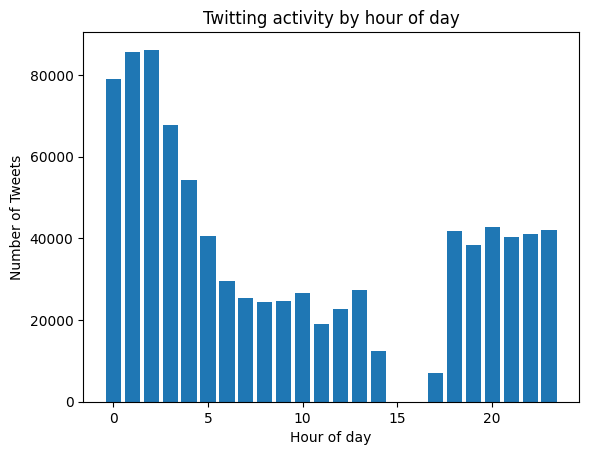

In [85]:
(x_values, y_values) = zip(*hour_count_df.collect())
plt.bar(x_values, y_values)
plt.title('Twitting activity by hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Number of Tweets')
plt.show()

This graph is quite enlightening. On the one hand, it looks like we have some missing Tweets, or is it that there were some hours of the US night in which there have been no Tweets? On the other hand, there is a clear trend of a higher number of Tweets during the day and a lower number during the night.

## 4. Deep dive into user mentions and hashtags

Let's now study user mentions and hashtags in Tweets.

### Most popular users

We will start getting the most mentioned usernames, that is, obtaining a DataFrame with the number of times each user has been mentioned, sorted by mentions.

**Note:** User mentions appear in the `user_mentions` column, which is an array. The way to unpack the array is by using the `explode` function. Once applied, another `select` can be made to keep only the name of the user (recall that the `screen_name` is the unique username).

In [88]:
df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- displayed_username: string (nullable = true)
 |-- username_id: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- text: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- country: string (nullable = true)
 |-- user_mentions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- timestamp: timestamp (nullable =

In [98]:
user_mentions_df = df.select(
    sql_f.explode(
        sql_f.col('user_mentions')
    ).alias('user_mentions')
).select(
    sql_f.col('user_mentions.screen_name').alias('screen_name')
).groupBy(
    sql_f.col('screen_name')
).count()\
.orderBy('count', ascending=False)

user_mentions_df.show(10)

25/12/06 18:10:18 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+-------------+-----+
|  screen_name|count|
+-------------+-----+
|  BarackObama|13751|
|   NICKIMINAJ| 9726|
|      YouTube| 5127|
|   MittRomney| 3955|
|    billmaher| 3906|
|    ShareThis| 3876|
|2ChainzLyrics| 3862|
|KattWillliams| 3059|
|     ppppolls| 2776|
| HumorOrTruth| 2097|
+-------------+-----+
only showing top 10 rows


In [99]:
test(user_mentions_df.take(10), [('BarackObama', 13751), ('NICKIMINAJ', 9726), ('YouTube', 5127),
                                 ('MittRomney', 3955), ('billmaher', 3906), ('ShareThis', 3876),
                                 ('2ChainzLyrics', 3862), ('KattWillliams', 3059), ('ppppolls', 2776),
                                 ('HumorOrTruth', 2097)], 'Try again!')

25/12/06 18:10:27 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


Test passed.


### Most popular hashtags

We can do the same with the hashtags. You may need to inspect the DataFrame schema to understand how you can get the text of the hashtags and count them. To avoid problems with capitalization, put all of them in lowercase.

In [100]:
# Check the schema
df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- displayed_username: string (nullable = true)
 |-- username_id: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- text: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- country: string (nullable = true)
 |-- user_mentions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- timestamp: timestamp (nullable =

In [101]:
top_tags_df = df.select(
    sql_f.explode(
        sql_f.col('hashtags')
    ).alias('hashtags')
).select(
    sql_f.lower(
        sql_f.col('hashtags.text')
    ).alias('text')
).groupBy(
    sql_f.col('text')
).count()\
.orderBy('count', ascending=False)

top_tags_df.show(10)

25/12/06 18:15:47 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+---------+-----+
|     text|count|
+---------+-----+
|    obama|30643|
|      usa|30405|
|     tcot|19116|
|       p2| 8608|
|   romney| 6171|
|     news| 4785|
|      gop| 4600|
|obama2012| 4179|
| teaparty| 4057|
|  somalia| 3636|
+---------+-----+
only showing top 10 rows


In [102]:
test(top_tags_df.take(10), [('obama', 30643), ('usa', 30405), ('tcot', 19116), ('p2', 8608), ('romney', 6171),
                            ('news', 4785), ('gop', 4600), ('obama2012', 4179), ('teaparty', 4057), 
                            ('somalia', 3636)], 'Try again!')

# test(top_10_tags.is_cached, True, 'DataFrame not cached!')

25/12/06 18:15:59 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


Test passed.


The results obtained are interesting. Obama is the most used hashtag, closely followed by USA, however, Romney, the Republican candidate, appeared in far fewer hashtags. Did the Republicans have less presence on Twitter?

Although the answer apparently could be yes, it is interesting to see that other hashtags such as 'tcot' appear, what does it refer to? The next article gives us the answer: <http://www.ibtimes.com/what-does-tcot-mean-about-tcot-hashtag-top-conservatives-use-twitter-1109812>

In short, it seems like the Republicans were not as focused on the candidate, but still had a presence on Twitter.

### Hashtags and user mentions

Let's see which pairs of hashtags and users appear most often together. This time we will maintain capitalization (i.e., do not use the `lower` function).

In summary, we want to get a DataFrame in which we have, the name of the mentioned user, the hashtag text and the count of how many times they have appeared together. The DataFrame must be sorted by count.

Remember that both hashtags and user mentions are stored in arrays that must be unpacked. To do this, keep in mind that you cannot use the `explode` function twice in the same `select`, and therefore they must be done separately in two consecutive steps.

In [105]:
mentions_hashtag_df = df.select(
    sql_f.explode(
        sql_f.col('user_mentions')
    ).alias('user_mentions'),
    sql_f.explode(
        sql_f.col('hashtags')
    ).alias('hashtags')
).select(
    sql_f.col('user_mentions.screen_name').alias('screen_name'),
    sql_f.col('hashtags.text').alias('text')
).groupBy(
    sql_f.col('screen_name'),
    sql_f.col('text')
).count()\
.orderBy(['count', 'text'], ascending=[False, True])

mentions_hashtag_df.show(10)

25/12/06 18:22:14 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)


+--------------+----------------+-----+
|   screen_name|            text|count|
+--------------+----------------+-----+
| ZupFollowBack|BillionDollarArt| 1317|
| ZupFollowBack|  TeamFollowBack| 1317|
| ZupFollowBack|             USA| 1295|
| ZupFollowBack|             NYC| 1293|
|  RCTV_CONTIGO|    ChávezCADUCÓ| 1231|
|  RCTV_CONTIGO|   ChavezGranCob| 1173|
|        cnnbrk|           Obama|  834|
|        cnnbrk|          Romney|  829|
|        cnnbrk|    CNNelections|  819|
|Son_of_Fratter|             USA|  697|
+--------------+----------------+-----+
only showing top 10 rows


In [106]:
test(mentions_hashtag_df.take(10), [('ZupFollowBack', 'BillionDollarArt', 1317), ('ZupFollowBack', 'TeamFollowBack', 1317),
                                ('ZupFollowBack', 'USA', 1295), ('ZupFollowBack', 'NYC', 1293), 
                                ('RCTV_CONTIGO', 'ChávezCADUCÓ', 1231), ('RCTV_CONTIGO', 'ChavezGranCob', 1173),
                                ('cnnbrk', 'Obama', 834), ('cnnbrk', 'Romney', 829), ('cnnbrk', 'CNNelections', 819),
                                ('Son_of_Fratter', 'USA', 697)], 'Try again!')

25/12/06 18:22:18 WARN MemoryStore: Not enough space to cache rdd_7_0 in memory! (computed 430.3 MiB so far)
[Stage 217:>                                                        (0 + 1) / 1]

Test passed.


### Pairs of hashtags

Let's study which pair of hashtags tend to appear together. Then, we will do the same with the user mentions.

You may wonder whether you can solve this without UDFs or not. Yes, you can. But you may check which solution is more efficient. So, let's implement two solutions, one avoiding UDFs and the other defining a UDF to generate hashtag pairs. From our point of view, the latter is more intuitive, but may not be so efficient.

**Hints for avoiding UDFs**

**CAUTION: This is a challenging exercise!** 

To avoid using UDFs you need to think of a way to make pairs of hashtags and then count them. One way to do so is by building a DataFrame that has in each row a `tweet_id` and a `hashtag` present in that Tweet. So, you would need to explode the `hashtags.text` field. Then, you could perform a join with that same DataFrame using the `tweet_id` column, so you will get two columns with the hashtag text. Be careful to ensure that both columns with hashtags have different names. You can also take a look at `array` and `array_sort` functions from `pyspark.sql.functions` to combine those pairs. Finally, take into account that with `join` you will generate all the pairs twice, so, you need to remove those duplicates.


In [5]:
test(df.is_cached, True, 'DataFrame not cached!')

Test failed. DataFrame not cached!


In [6]:
df.cache()

DataFrame[tweet_id: bigint, displayed_username: string, username_id: string, followers_count: bigint, text: string, retweet_count: bigint, country: string, user_mentions: array<struct<id:bigint,id_str:string,indices:array<bigint>,name:string,screen_name:string>>, hashtags: array<struct<indices:array<bigint>,text:string>>, created_at: string]

In [7]:
test(df.is_cached, True, 'DataFrame not cached!')

Test passed.


In [16]:
hashtags_df = df.select(
    sql_f.col('tweet_id'),
    sql_f.explode(
        sql_f.col('hashtags.text')
    ).alias('hashtags')
)

pairs_count_df = hashtags_df.join(
    hashtags_df.withColumnRenamed('hashtags', 'hashtags_dup'),
    'tweet_id'
).withColumn(
    'hashtag_pairs',
    sql_f.array_sort(
        sql_f.array(
            sql_f.col('hashtags'),
            sql_f.col('hashtags_dup')
        )
    )
).filter(
    sql_f.col('hashtags') != sql_f.col('hashtags_dup')
).dropDuplicates(['tweet_id', 'hashtag_pairs'])\
.groupBy(
    sql_f.col('hashtag_pairs')
).count()\
.orderBy('count', ascending=False)

pairs_count_df.show(10)

[Stage 49:>                                                         (0 + 4) / 4]

+--------------------+-----+
|       hashtag_pairs|count|
+--------------------+-----+
|          [p2, tcot]| 4429|
|     [Obama, Romney]| 3680|
|    [tcot, teaparty]| 2725|
|        [tcot, tlot]| 2303|
|[BillionDollarArt...| 2020|
|[TeamFollowBack, ...| 2004|
|[BillionDollarArt...| 1999|
|       [Obama, tcot]| 1875|
|          [NYC, USA]| 1846|
|         [gop, tcot]| 1708|
+--------------------+-----+
only showing top 10 rows


In [17]:
# <FILL-IN WITH YOUR CODE>

You could now measure the runtime of this solution. Recall that you can do this with `%time` in the execution line or `%%time` for the whole cell.

In [18]:
%time pairs_count_df.take(10)

[Stage 58:>                                                         (0 + 4) / 4]

CPU times: user 2.92 ms, sys: 2.06 ms, total: 4.98 ms
Wall time: 1.83 s


[Row(hashtag_pairs=['p2', 'tcot'], count=4429),
 Row(hashtag_pairs=['Obama', 'Romney'], count=3680),
 Row(hashtag_pairs=['tcot', 'teaparty'], count=2725),
 Row(hashtag_pairs=['tcot', 'tlot'], count=2303),
 Row(hashtag_pairs=['BillionDollarArt', 'TeamFollowBack'], count=2020),
 Row(hashtag_pairs=['TeamFollowBack', 'USA'], count=2004),
 Row(hashtag_pairs=['BillionDollarArt', 'USA'], count=1999),
 Row(hashtag_pairs=['Obama', 'tcot'], count=1875),
 Row(hashtag_pairs=['NYC', 'USA'], count=1846),
 Row(hashtag_pairs=['gop', 'tcot'], count=1708)]

**Hints for using UDFs**

In this case, you will need to create a UDF that returns an array of arrays of strings (`ArrayType(ArrayType(StringType()))`) having generated the pairs of hashtags. Be careful, there may be repeated hashtags in the same Tweet that we don't want to count as pairs, so you may need to remove duplicate pairs with the same `tweet_id`. The rest is nothing new, just grouping and counting.

In [23]:
from pyspark.sql.types import ArrayType, StringType

@sql_f.udf(ArrayType(ArrayType(StringType())))
def create_hashtag_pairs(hashtags):
    hashtag_pairs = []
    for hashtag_1 in hashtags:
        for hashtag_2 in hashtags:
            if hashtag_1.text != hashtag_2.text:
                hashtag_pairs.append(sorted([hashtag_1.text, hashtag_2.text]))
    return hashtag_pairs

pairs_count_df = df.select(
    sql_f.col('tweet_id'),
    sql_f.explode(
        create_hashtag_pairs(
            sql_f.col('hashtags')
        )
    ).alias('hashtag_pairs')
).distinct()\
.groupBy(
    sql_f.col('hashtag_pairs')
).count()\
.orderBy('count', ascending=False)

pairs_count_df.show(10, truncate=False)

[Stage 72:>                                                         (0 + 1) / 1]

+----------------------------------+-----+
|hashtag_pairs                     |count|
+----------------------------------+-----+
|[p2, tcot]                        |4429 |
|[Obama, Romney]                   |3680 |
|[tcot, teaparty]                  |2725 |
|[tcot, tlot]                      |2303 |
|[BillionDollarArt, TeamFollowBack]|2020 |
|[TeamFollowBack, USA]             |2004 |
|[BillionDollarArt, USA]           |1999 |
|[Obama, tcot]                     |1875 |
|[NYC, USA]                        |1846 |
|[gop, tcot]                       |1708 |
+----------------------------------+-----+
only showing top 10 rows


In [24]:
test(pairs_count_df.take(10), [(['p2', 'tcot'], 4429), (['Obama', 'Romney'], 3680), (['tcot', 'teaparty'], 2725),
                                (['tcot', 'tlot'], 2303), (['BillionDollarArt', 'TeamFollowBack'], 2020),
                                (['TeamFollowBack', 'USA'], 2004), (['BillionDollarArt', 'USA'], 1999),                    
                                (['Obama', 'tcot'], 1875), (['NYC', 'USA'], 1846), (['gop', 'tcot'], 1708)],
     'Try it again!')

[Stage 78:>                                                         (0 + 1) / 1]

Test passed.


Don't forget to measure the time and compare it with the previous solution. Is it truly slower in this case? Why?

In [25]:
%time pairs_count_df.show(10, truncate=False)

[Stage 84:>                                                         (0 + 1) / 1]

+----------------------------------+-----+
|hashtag_pairs                     |count|
+----------------------------------+-----+
|[p2, tcot]                        |4429 |
|[Obama, Romney]                   |3680 |
|[tcot, teaparty]                  |2725 |
|[tcot, tlot]                      |2303 |
|[BillionDollarArt, TeamFollowBack]|2020 |
|[TeamFollowBack, USA]             |2004 |
|[BillionDollarArt, USA]           |1999 |
|[Obama, tcot]                     |1875 |
|[NYC, USA]                        |1846 |
|[gop, tcot]                       |1708 |
+----------------------------------+-----+
only showing top 10 rows
CPU times: user 2.88 ms, sys: 1.23 ms, total: 4.12 ms
Wall time: 7.82 s


You may see that there is almost no difference in the solutions in this case. The problem is that to avoid UDFs we have gone through costly operations that are hindering performance. So, in this case, UDFs may be preferred.

### Pairs of user mentions

We will repeat the previous analysis with user mentions. Are certain users mentioned in pairs very frequently?

In [26]:
df.printSchema()

root
 |-- tweet_id: long (nullable = true)
 |-- displayed_username: string (nullable = true)
 |-- username_id: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- text: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- country: string (nullable = true)
 |-- user_mentions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- created_at: string (nullable = true)



In [42]:
from pyspark.sql.types import ArrayType, StringType

@sql_f.udf(ArrayType(ArrayType(StringType())))
def create_user_pairs(user_mentions):
    user_pairs = []
    for user_1 in user_mentions:
        for user_2 in user_mentions:
            if user_1.screen_name != user_2.screen_name:
                user_pairs.append(sorted([user_1.screen_name, user_2.screen_name]))
    return user_pairs

user_pairs_count_df = df.select(
    sql_f.col('tweet_id'),
    sql_f.explode(
        create_user_pairs(
            sql_f.col('user_mentions')
        )
    ).alias('user_pairs')
).distinct()\
.groupBy(
    sql_f.col('user_pairs')
).count()\
.orderBy(
    sql_f.col('count').desc(),
    sql_f.lower(sql_f.col('user_pairs').getItem(1)).desc()
)

user_pairs_count_df.show(10, truncate=False)

[Stage 135:>                                                        (0 + 1) / 1]

+------------------------------+-----+
|user_pairs                    |count|
+------------------------------+-----+
|[BarackObama, MittRomney]     |817  |
|[BarackObama, NICKIMINAJ]     |706  |
|[BarackObama, NiallOfficial]  |499  |
|[AlfredoFlores, justinbieber] |498  |
|[BarackObama, justinbieber]   |496  |
|[AlfredoFlores, NiallOfficial]|494  |
|[NiallOfficial, justinbieber] |494  |
|[AlfredoFlores, BarackObama]  |494  |
|[Lord_Sugar, piersmorgan]     |479  |
|[BIGGEST_BARB, NICKIMINAJ]    |359  |
+------------------------------+-----+
only showing top 10 rows


In [43]:
test(user_pairs_count_df.take(10), [(['BarackObama', 'MittRomney'], 817), (['BarackObama', 'NICKIMINAJ'], 706),
                               (['BarackObama', 'NiallOfficial'], 499), (['AlfredoFlores', 'justinbieber'], 498),
                               (['BarackObama', 'justinbieber'], 496), (['AlfredoFlores', 'NiallOfficial'], 494),
                               (['NiallOfficial', 'justinbieber'], 494), (['AlfredoFlores', 'BarackObama'], 494),
                               (['Lord_Sugar', 'piersmorgan'], 479), (['BIGGEST_BARB', 'NICKIMINAJ'], 359)],
     'Try it again!')

[Stage 141:>                                                        (0 + 1) / 1]

Test passed.


It could be expected that Obama and Romney were going to be mentioned a lot together. Could you tell us something about the other pairs?

### Presence of the candidates in the Tweets

In the previous exercises, we only focused on hashtags and user mentions, but we did not pay attention to the text of the Tweets. In the following exercise, we are going to try to find out how many Tweets each party/candidate was present. We should be aware that a higher presence does not always have to be positive (but this would require a much deeper analysis).

To simplify the task, we will assume that the words related to each candidate/party are:
* Obama/Democrats: 'obama' and 'democrat;
* Romney/Republicans: 'romney', 'republican', 'teaparty' and 'tcot'.

Our first objective is to create a DataFrame in which we have a column that indicates if it mentions Obama/democrats and another one if it mentions Romney/republicans.

To accomplish this task, we will follow the steps below.
1. We will just work with the Tweet text (as it also contains the hashtags and user mentions). So, start getting a new DataFrame with just this information. Name it `tweet_text_df`. Put all the text in lowercase, so that, it eases the pattern matching we will be doing next.
2. Add a new column to `tweet_text_df` called `democrat`, which will indicate if any of the words corresponding to democrats ('obama', 'democrat') have been mentioned in that tweet. If any of them has been mentioned, the column will have the value 'Democrat' and otherwise the value '-'. To do this, make use of `withColumn` and the `when/otherwise` functions.
3. Check the number of Tweets in which democrats appear by grouping and counting on the new column. Store the result in `democrat_count_df`.

In [45]:
#df.printSchema()

In [52]:
tweet_text_df = df.select(
    sql_f.lower(
        sql_f.col('text')
    ).alias('text')
)
democrat_count_df = tweet_text_df.select(
    sql_f.col('text')
).withColumn(
    'democrat',
    sql_f.when(
        sql_f.col('text').rlike("|".join(['obama', 'democrat'])),
        'Democrat'
    ).otherwise(
        '-'
    )
).groupBy(
    sql_f.col('democrat')
).count()

democrat_count_df.show(10)

[Stage 157:>                                                        (0 + 1) / 1]

+--------+------+
|democrat| count|
+--------+------+
|Democrat|532483|
|       -|467517|
+--------+------+



In [53]:
test(democrat_count_df.take(10), [('Democrat', 532483), ('-', 467517)], 'Try it again!')

[Stage 160:>                                                        (0 + 1) / 1]

Test passed.


4. Repeat the previous step to add another column for the Republican mentions ( 'romney', 'republican', 'teaparty' and 'tcot'). The new column will be called `Republican`.
5. Again, check the number of Tweets in which republicans appear by grouping and counting (store it in `republican_count_df`.

In [54]:
republican_count_df = tweet_text_df.select(
    sql_f.col('text')
).withColumn(
    'republican',
    sql_f.when(
        sql_f.col('text').rlike("|".join(['romney', 'republican', 'teaparty', 'tcot'])),
        'Republican'
    ).otherwise(
        '-'
    )
).groupBy(
    sql_f.col('republican')
).count()

republican_count_df.show(10)

[Stage 163:>                                                        (0 + 1) / 1]

+----------+------+
|republican| count|
+----------+------+
|Republican|167286|
|         -|832714|
+----------+------+



In [55]:
test(republican_count_df.take(10), [('Republican', 167286), ('-', 832714)], 'Try it again!')

[Stage 166:>                                                        (0 + 1) / 1]

Test passed.


We can use the DataFrame we have created to obtain the percentage of Tweets in which only democrats, only republicans, both democrats and republicans and none of them are mentioned. Round the percentages to 4 decimals and store the result in `party_percentage_df` (the percentages should be ordered in descending order).

In [58]:
party_percentage_df = tweet_text_df.select(
    sql_f.col('text')
).withColumn(
    'democrat',
    sql_f.when(
        sql_f.col('text').rlike("|".join(['obama', 'democrat'])),
        'Democrat'
    ).otherwise(
        '-'
    )
).withColumn(
    'republican',
    sql_f.when(
        sql_f.col('text').rlike("|".join(['romney', 'republican', 'teaparty', 'tcot'])),
        'Republican'
    ).otherwise(
        '-'
    )
).groupBy(
    sql_f.col('democrat'),
    sql_f.col('republican')
).count()\
.select(
    sql_f.col('democrat'),
    sql_f.col('republican'),
    sql_f.round(
        100.0 * (sql_f.col('count') / tweet_text_df.count()),
        4
    ).alias('percentage')
).orderBy('percentage', ascending=False)

party_percentage_df.show(10)

[Stage 179:>                                                        (0 + 1) / 1]

+--------+----------+----------+
|democrat|republican|percentage|
+--------+----------+----------+
|       -|         -|   44.9856|
|Democrat|         -|   38.2858|
|Democrat|Republican|   14.9625|
|       -|Republican|    1.7661|
+--------+----------+----------+



In [59]:
test(party_percentage_df.take(10), [ ('-', '-', 44.9856), ('Democrat', '-', 38.2858), 
                                     ('Democrat', 'Republican', 14.9625), ('-', 'Republican', 1.7661)],
     'Try it again!')

[Stage 182:>                                                        (0 + 1) / 1]

Test passed.


Once again, the result shows that the Democrats have apparently more presence. Perhaps it is because the Republicans were only criticizing them, or because the Democrats really focused much more on social networks.

## 5. Use your imagination to further explore the dataset of tweets and draw new conclusions

To do this, describe the statement of the task you are going to perform and then solve it. To write the statement, use Markdown cells.

For example, you can try to.
* Count tweets per day/hour and relate it to parties or countries.
* Study the users who have the most followers.
* Quantify the hate, counting the number of insults and calculate percentages to know to which party they were more directed to.
* Perform a sentiment analysis based on positive and negative words ([check this](https://nealcaren.org/lessons/wordlists/)).
* Study if there is a correlation between the number of retweets and followers.
* ...

### Quantifying hate
Now, we will analyze which party received more direct hate. We will base this query on the previous one, but we will make some changes:
- First, we will create a "hate" column to classify the tweet into one that contains an insult or into one that doesn't.
- Second, we will filter the DataFrame to only maintain tweet containing insults.
- Finally, we will filter again the DataFrame to delete tweets that aren't directed to any party and also the ones that are directed to both parties. This way we will get the tweets that contain insults and that are directed only to democrats or only to republicans.

In [61]:
insults = ['idiot', 'asshole', 'dumb', 'braindead', 'motherfucker', 'stupid', \
           'fag', 'faggot', 'retarded', 'dumbshit', 'retard']

In [74]:
hate_df = tweet_text_df.select(
    sql_f.col('text')
).withColumn(
    'democrat',
    sql_f.when(
        sql_f.col('text').rlike("|".join(['obama', 'democrat'])),
        'Democrat'
    ).otherwise(
        '-'
    )
).withColumn(
    'republican',
    sql_f.when(
        sql_f.col('text').rlike("|".join(['romney', 'republican', 'teaparty', 'tcot'])),
        'Republican'
    ).otherwise(
        '-'
    )
).withColumn(
    'hate',
    sql_f.when(
        sql_f.col('text').rlike("|".join(insults)),
        'Insulted'
    ).otherwise(
        '-'
    )
).filter(
    sql_f.col('hate') == 'Insulted'
).filter(
    (
        (sql_f.col('democrat') == 'Democrat') &
        (sql_f.col('republican') == '-')
    ) | (
        (sql_f.col('democrat') == '-') & 
        (sql_f.col('republican') == 'Republican')
    )
).groupBy(
    sql_f.col('democrat'),
    sql_f.col('republican')
).count()\
.withColumnRenamed(
    'count',
    'times_insulted'
)

total_insulted = hate_df.agg(
    sql_f.sum('times_insulted')
).first()[0]

hate_percentage_df = hate_df.select(
    '*',
    sql_f.round(
        100.0 * (sql_f.col('times_insulted') / total_insulted),
        4
    ).alias('percentage')
)

hate_percentage_df.show(10)

[Stage 202:>                                                        (0 + 1) / 1]

+--------+----------+--------------+----------+
|democrat|republican|times_insulted|percentage|
+--------+----------+--------------+----------+
|Democrat|         -|          5062|   95.3655|
|       -|Republican|           246|    4.6345|
+--------+----------+--------------+----------+



### Summary
Interesting... It seems that the democrats receibed too much hate compared to the republicans.